# Teste A/B - Pipeline

Esse notebook tem o objetivo de apresentar um passo-a-passo para a criação de testes A/B em um ambiente realista. Utilizaremos o case TeraBuy apresentado em sala de aula.

A [primeira parte](#Parte-1) do notebook contém uma análise exploratória dos dados da empresa TeraBuy. Essa parte é fundamental, pois nos permite entender o comportamento dos nossos clientes. Apenas assim podemos criar hipóteses sólidas para podermos verificar através de testes A/B.

A [segunda parte](#Parte-2) será dividida em dois cases distintos. O primeiro case utilizará um teste A/B para verificar se a mudança de cor do botão da página inicial poderia aumentar a taxa de pessoas que entram na página de produto. O segundo case utilizará um teste A/B no final do funil. Verificaremos se podemos aumentar a nossa taxa de conversão, assim como nosso lucro, ao darmos desconto no frete dos nossos produtos. Esse teste é muito sensível, pois envolve a possibilidade de prejuízo para nossa empresa.

Ao [final](#Teste-de-Hipóteses) do notebook há uma seção com uma revisão de testes de hipóteses com um exemplo.

In [6]:
%matplotlib inline
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
# Parte 1
## Análise Exploratória - TeraBuy

![TeraBuy](../imagens/terabuy_controle.png)

---

O nosso principal objetivo como criadores da próxima Amazon do setor de educação (temos que sonhar grande mesmo!) é gerar impacto aos nossos clientes e, consequentemente, gerar lucro. O maior problema das empresas é que elas não conhecem seus clientes, ou pior, elas *acham* que conhecem. Todo cientista precisa ser cético em relação a seus dados e, portanto, precisamos tirar o máximo de informação de nossa população (clientes). Somente quando tivermos confiáveis em relação a essa etapa é que podemos criar e testar hipóteses (testes A/B).

Com a finalidade de aumentarmos nosso conhecimento sobre nossos clientes, suponha que fizemos uma amostragem aleatória dos acessos únicos ao site em um dado período de tempo. Esse arquivo se encontra na pasta `data/exp_clientes.csv`. Esse arquivo contém as seguintes informações:

- **`age`**: Idade dos usuários loggados (não é comum termos essa informação, mas será útil para analisarmos o perfil dos clientes)
- **`start_click`**: Uma flag que indica se o usuário clicou no botão de comprar da página inicial
- **`session_time`**: Tempo que o cliente permaneceu no site (minutos)
- **`converted`**: Uma flag que indica se o usuário finalizou a compra
- **`ticket_price`**: Indica o preço do produto comprado pelo cliente
- **`shipping`**: Preço do frete do equipamento comprado

In [23]:
# Função com algumas estatísticas de sumário úteis
def stats_describe(x):
    print("média:         {:.2f}".format(np.mean(x)))
    print("desvio padrão: {:.2f}".format(np.std(x)))
    print("mínimo:        {:.2f}".format(min(x)))
    print("25% percentil: {:.2f}".format(np.percentile(x, 25)))
    print("50% percentil: {:.2f} (mediana)".format(np.median(x)))
    print("75% percentil: {:.2f}".format(np.percentile(x, 75)))
    print("máximo:        {:.2f}".format(max(x)))
    
    plt.hist(x)
    plt.show()

In [29]:
df = pd.read_csv(filepath_or_buffer='../data/exp_clientes.csv')

df.head(10)

,age,start_click,session_time,converted,ticket_price,shipping
0,37.0,0,11,0,0.000000,0
1,36.0,0,4,0,0.000000,0
2,30.0,1,16,0,0.000000,0
3,35.0,1,16,1,75.521313,22
4,41.0,0,8,0,0.000000,0
5,23.0,1,14,0,0.000000,0
6,35.0,1,6,0,0.000000,0
7,40.0,1,10,0,0.000000,0
8,45.0,1,12,1,91.256230,11
9,38.0,1,8,0,0.000000,0


Quantidade de dados obtidos:

In [30]:
len(df)

20236

Qual é a distribuição de idade dos clientes?

média:         35.02
desvio padrão: 5.00
mínimo:        20.00
25% percentil: 32.00
50% percentil: 35.00 (mediana)
75% percentil: 38.00
máximo:        55.00


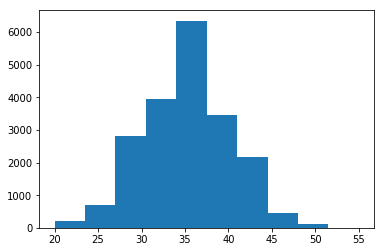

In [27]:
stats_describe(df['age'])

Percebemos que o nosso cliente possui, em média, 35 anos de idade. Não temos outras informações pessoais do nosso cliente, mas poderia ser útil saber qual é o sexo predominante que acessa nosso site, além de outras informações. Esse tipo de informação pode fazer toda a diferença ao criar o plano de negócios da empresa.

*Exemplo: O Elo7 leva muito a sério o perfil dos seus clientes. Nós sabemos, por exemplo, que o perfil mais usual dos nossos clientes é uma mulher de cerca de 35 anos, com um filho e com interesse por produtos infantis e de casamento. Esse perfil nos auxilia em todas as nossas campanhas de marketing e na forma como nos comunicamos com nossos clientes, já que agora sabemos quem ele é.*

Podemos agora tentar achar uma correlação entre cliques e idade média dos usuários.

- Será que há alguma diferença de idade entre as pessoas que clicam ou não no botão da página inicial? Pode ser que isso indique algum comportamento não esperado nos nossos usuários.

Cliente clicou!
---------------
média:         35.01
desvio padrão: 5.00
mínimo:        20.00
25% percentil: 32.00
50% percentil: 35.00 (mediana)
75% percentil: 38.00
máximo:        53.00


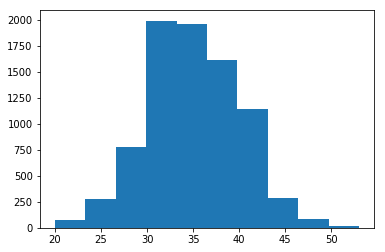

----------------------------------------
Cliente não clicou!
-------------------
média:         35.02
desvio padrão: 5.00
mínimo:        20.00
25% percentil: 32.00
50% percentil: 35.00 (mediana)
75% percentil: 38.00
máximo:        55.00


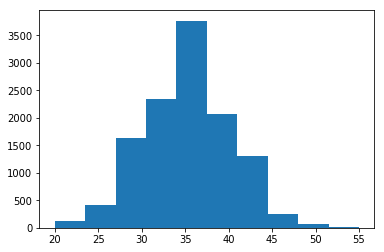

In [34]:
print("Cliente clicou!")
print("---------------")
stats_describe(df[df['start_click']==1]['age'])
print("-"*40)
print("Cliente não clicou!")
print("-------------------")
stats_describe(df[df['start_click']==0]['age'])

Pelo jeito não há diferença. As estatísticas parecem semelhantes.

Agora vem uma pergunta muito importante: 
- Qual é taxa de cliques (CTR) no botão da página inicial?

In [35]:
print("CTR: {:.2%}".format(df['start_click'].mean()))

CTR: 40.68%


- E quanto tempo os clientes permanecem no nosso site?

Essa pergunta é muito útil, porque nos auxilia a entender o comportamento dos nosso usuários com nosso conteúdo.
Por exemplo, a Amazon percebeu que quanto menos tempo uma pessoa passa no site dela, maior a probabilidade de um usuário finalizar uma compra. Por isso, se a empresa deseja aumentar a taxa de conversão, ela poderia simplificar as etapas de compra para tornar o processo mais rápido. Já no Elo7, há um comportamento diferente do nosso usuário. Como nossos produtos são personalizados e únicos, os usuários não sabem exatamente o que estão procurando. Por esse modo, um menor tempo de permanência no site não significa que aumentará a nossa probabilidade de conversão. E no caso da **TeraBuy**? Como será o comportamento do nosso usuário?

média:         8.81
desvio padrão: 3.12
mínimo:        0.00
25% percentil: 7.00
50% percentil: 9.00 (mediana)
75% percentil: 11.00
máximo:        22.00


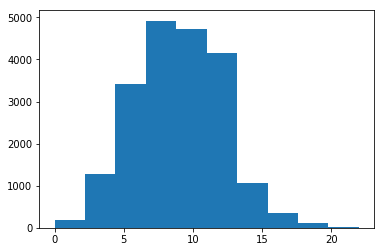

In [36]:
stats_describe(df['session_time'])

- Será que há alguma correlação entre a pessoa clicar no botão "comprar" e o tempo que ela permanece no site?

Cliente clicou!
---------------
média:         9.98
desvio padrão: 3.16
mínimo:        1.00
25% percentil: 8.00
50% percentil: 10.00 (mediana)
75% percentil: 12.00
máximo:        22.00


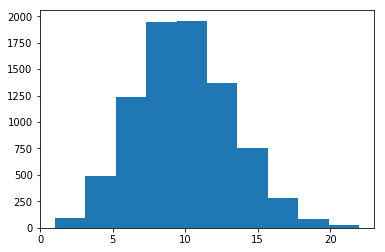

----------------------------------------
Cliente não clicou!
-------------------
média:         8.00
desvio padrão: 2.83
mínimo:        0.00
25% percentil: 6.00
50% percentil: 8.00 (mediana)
75% percentil: 10.00
máximo:        20.00


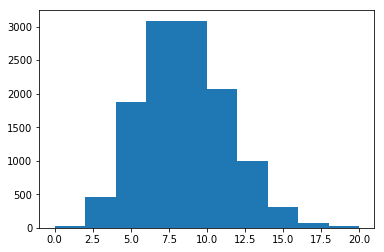

In [37]:
print("Cliente clicou!")
print("---------------")
stats_describe(df[df['start_click']==1]['session_time'])
print("-"*40)
print("Cliente não clicou!")
print("-------------------")
stats_describe(df[df['start_click']==0]['session_time'])

Pelo jeito há alguma correlação. ***Pode*** haver uma relação entre os usuários que clicam no botão inicial e o tempo de permanência no nosso site. Lembre-se sempre que "Correlação não indica causalidade"! Precisariamos de testes mais profundos para criar uma análise de causalidade.

- Qual é a taxa de conversão do nosso e-commerce? Essa é uma boa medida para indicar a saúde financeira do nosso site.

In [39]:
print("Taxa de conversão: {:.2%} (Homepage)".format(df['converted'].mean()))
print("Taxa de conversão: {:.2%} (Página produto)".format(df[df['start_click']==1]['converted'].mean()))

Taxa de conversão: 8.45% (Homepage)
Taxa de conversão: 20.77% (Página produto)


Percebemos que cerca de 8% das pessoas que entram no nosso site (homepage) compram algum produto. E cerca de 20% das pessoas que entram na página de produto convertem. Esses números são bons ou ruins? Você pode tirar essas informações de seu histórico de análises ou informações a respeito de empresas semelhantes a sua. Sempre gostaríamos de otimizar esses números e, portanto, podemos realizar testes A/B para testarmos novas funcionalidades. 

E o nosso frete? Existe um problema comum a todos os e-commerce que entregam produtos via correios que é o preço do frete.

média:         20.01
desvio padrão: 4.95
mínimo:        5.00
25% percentil: 17.00
50% percentil: 20.00 (mediana)
75% percentil: 23.00
máximo:        34.00


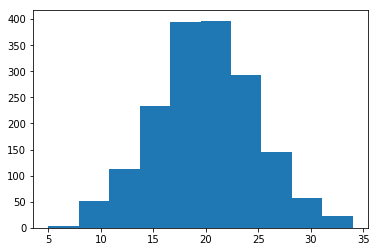

In [40]:
stats_describe(df[df['converted']==1]['shipping']) # Note que temos que considerar apenas os preços de produtos comprados

Até então não sabemos se esses valores são altos ou baixos. Temos a impressão de que isso depende do preço do nosso produto também. Podemos verificar qual é o preço médio pago pelos clientes no nosso site.

média:         100.20
desvio padrão: 21.00
mínimo:        25.74
25% percentil: 85.83
50% percentil: 100.18 (mediana)
75% percentil: 114.96
máximo:        165.17


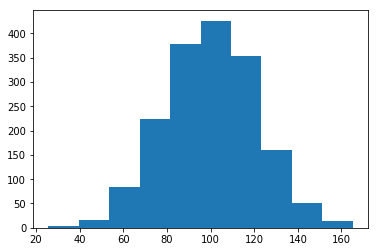

In [42]:
stats_describe(df[df['converted']==1]['ticket_price'])

Em média, nosso cliente paga R\$100,00 por compra (ticket médio). Os valores de frete e ticket médio nos dá um indicativo de comportamento do nosso usuário, mas não nos diz quais são os valores ótimos que deveríamos atingir. As vezes, um valor frete alto aumenta o valor de ticket médio, mas isso não se reflete em lucro, porque apenas quer dizer que o cliente só aceita pagar nosso frete se for para comprar um produto caro. Portanto, esses números sozinhos não são indicativos de saúde financeira da empresa.

Exemplo: Suponha que você seja um cliente da TeraBuy e quisesse comprar um produto de R\$20,00, mas o frete dele é R\$30,00. Você compraria esse produto? E se o seu produto custasse R\$300,00? Provavelmente você não ligaria de pagar os R\$30,00 de frete na segunda opção. Por esse motivo é que um valor de frete alto também aumenta o ticket médio da empresa.

Exemplo 2: Suponha agora que 20 clientes estavam interessados em comprar o primeiro produto do exemplo anterior, mas só um cliente gostaria de comprar o segundo produto. Com o preço do frete, os 20 clientes desistem do primeiro produto e apenas o outro cliente finaliza a compra. Ao final, o ticket médio seria de R\$300,00 e receberíamos esse mesmo valor. Mas, se todos os 21 clientes tivessem comprado, o ticket médio se tornaria aproximadamente R\$33,00 e receberíamos R\$700,00 (sem contar o valor do frete). Portanto, ticket médio e valor do frete são sintomas da saúde financeira da empresa, mas não podem ser analisados sozinhos.


---
# Parte 2
## Case 1 - Teste A/B cor do botão da homepage

Todo teste A/B deve começar com um entendimento claro do problema que devemos atacar. Precisamos entender qual o objetivo que queremos atingir e que métricas vamos utilizar para verificar o sucesso.

Suponha o seguinte cenário para esse exercício: 
- Ao analisar os dados do TeraBuy, notamos que recebemos um bom tráfego de pessoas na nossa homepage, mas temos uma baixa taxa de pessoas que clicam (CTR: "click-through rate") no botão "compre já!" e, consequentemente, temos uma baixa taxa de conversão (proporção das pessoas que finalizam a compra). Ao levantar as possíveis hipóteses para esse fenômeno, a equipe de front-end sugeriu mudar a cor do botão (afinal, verde não é bonito). Mas, como cético que você é, você cria a sua hipótese inicial: "Será que a mudança da cor do botão mudaria o comportamento dos usuários?". Vamos realizar um teste A/B! (finalmente!)

Página do experimento:
![TeraBuy](../imagens/terabuy_experimento.png)

Agora podemos definir claramente nossos objetivos e métricas:

- **Objetivo**: Verificar variação na taxa de cliques do botão "compre já" na homepage do TeraBuy a partir da mudança de cor do mesmo.

- **Métricas**: Taxa de cliques no botão (CTR)
(Pergunta: Por que não utilizar a taxa de conversão como métrica?)

Detalhes técnicos (ir)relevantes: Cada usuário que entra no site recebe um identificador único, que é chamado de "cookie", e está associado ao seu ip. Dessa forma, podemos acompanhar o comportamento do cliente no site durante sua sessão. Quando realizamos um teste A/B, nós associamos aleatoriamente um dado cookie a um determinado "bucket" ("A" ou "B"). O cookie associado ao bucket "A" não perceberá qualquer variação no site, enquanto que o cookie associado ao bucket "B" visualizará o conteúdo de teste. Todos os cookies associados ao bucket "A" entram no que chamamos de "grupo de controle", enquanto que os outros estarão no "grupo de experimento".

#### Geração de dados do teste

A classe `ColorABTest` contém o dataframe com os dados do teste A/B realizado. Diferentemente do dataframe utilizado anteriormente, esse dataframe contém uma coluna chamada "bucket", que indica se o usuário viu ou não a nova funcionalidade. Ou seja, se bucket=1, o usuário viu o botão vermelho. 

O dataset a ser utilizado para o teste A/B é gerado com valores aleatórios, mas com a distribuição e parâmetros reais aos encontrados em testes A/B realizados anteriormente para outros fins (top secret!). Note que o fato de ser aleatório nos permite verificar que cada teste A/B realizado pode nos dar resultados diferentes. É exatamente essa incerteza que nós estamos interessados em mensurar.

In [12]:
# Algoritmo para calculo do mínimo tamanho de amostra.
# Mesmo algoritmo utilizado em http://www.evanmiller.org/ab-testing/sample-size.html
def calc_min_sample_size(alpha=0.05, beta=0.2, tails=2, base_prop=0.5, min_effect=0.0):
    sig1 = np.sqrt(2*base_prop*(1-base_prop))
    sig2 = np.sqrt(base_prop*(1-base_prop)+(base_prop+min_effect)*(1-base_prop-min_effect))
    sample_size = ((st.norm.ppf(1-alpha/tails)*sig1 + st.norm.ppf(1-beta)*sig2)/min_effect)**2
    return int(sample_size)

---
# Teste de Hipóteses
## Revisão

Em estatística, o teste de hipóteses é uma ferramenta poderosa para validar (ou invalidar) hipóteses sobre populações.

Normalmente, temos uma amostra de controle (ou uma população conhecida) e gostaríamos de saber se uma nova amostra obtida pode ter sido obtida da mesma população ou não. Ou seja, será que esse novo conjunto de dados possui alguma diferença em relação ao que tínhamos na população de controle?

---
*Para entender esse conceito, imagine o seguinte cenário: Suponha que temos duas caixas, sendo que uma contém 95 bolas azuis e 5 vermelhas, que definimos como nossa população de controle, e a outra contém 95 bolas vermelhas e 5 azuis. Agora suponha que alguém retire aleatoriamente e com reposição 3 bolas vermelhas de uma das caixas (amostra do experimento) e lhe diz que retirou todas as bolas da primeira caixa. Você acreditaria nessa hipótese? A probabilidade de alguém tirar 3 bolas vermelhas em seguida e com reposição da primeira caixa é de
$$\left(\frac{5}{100}\right)^{3}=0.0125\%$$
Portanto, apesar de haver alguma probabilidade, podemos rejeitar essa hipótese com 99.99% de confiança e afirmar que temos evidências suficientes para afirmar que a população de controle (caixa 1) não gerou essa amostra de experimento (3 bolas vermelhas). *

---

Esse teste é muito útil para verificar variações de tratamento de remédios, testes de novos métodos de produção na indústria ou mesmo em testes A/B!

Nessa aula, vamos focar em testes hipóteses entre proporções de populações diferentes. Esses testes serão úteis para executarmos nossa tarefa de testes A/B no nosso e-commerce TeraBuy!

O **teste de hipóteses** sempre começa com a definição das **hipóteses nula** ($H_0$) e **alternativa** ($H_1$). A hipótese nula é normalmente escolhida para definir que não há variação ($H_0: \mu_1 = \mu_2$, onde $\mu$ pode indicar uma proporção, média ou qualquer outro parâmetro comparável da população) entre a população de controle ($P_1$) e a população de experimento ($P_2$). Essa definição de hipótese nula é chamada de "**bilateral**", porque qualquer variação positiva ou negativa fará com que a hipótese seja rejeitada, ou seja, escolhemos a hipótese alternativa ($H_1: \mu_1 \neq \mu_2$). Alternativamente, a hipótese nula "**unilateral**" considera apenas a variação positiva ou a negativa para o teste de hipóteses. Portanto, o teste de hipóteses vai avaliar se a população de experimento sofreu variação positiva (no caso do teste de variação positiva $H_0: \mu_1 \leq \mu_2$ | $H_1: \mu_1 > \mu_2$) ou negativa (no caso do teste de variação negativa $H_0: \mu_1 \geq \mu_2$ | $H_1: \mu_1 < \mu_2$).

---
*Exemplo: Utilizando o exemplo das caixas apresentado anteriormente, a nossa hipótese nula seria a de que as 3 bolas vermelhas foram retiradas da caixa 1. Por consequência, a hipótese alternativa nos diria que a nossa amostra não foi retirada da caixa 1.*

---

O teste de hipóteses que vamos utilizar ao longo da aula será o teste "bilateral".

- $H_0: \mu_1 = \mu_2$
- $H_1: \mu_1 \neq \mu_2$

### Exemplo: 

Suponha que temos duas moedas ($P_1$ e $P_2$). A moeda $P_1$ é conhecida e sabemos que a probabilidade de sair "cara" é 50%, ou seja, é honesta. Precisamos agora definir se a moeda $P_2$ é honesta também. Com esse objetivo, nós realizamos 10 vezes o lançamento da moeda e contamos quantas vezes a "cara" apareceu.

O primeiro passo para o teste de hipóteses é definir a hipótese nula. Nesse caso, vamos definir $H_0$ como sendo a hipótese de que a moeda é honesta, ou seja, o número de "caras" em 10 lançamentos deve ser o mesmo do número de "coroas".

Vamos realizar um experimento considerando uma moeda honesta:

In [7]:
coin_outcomes = ['head', 'tail']

k = 10 # lancamentos

def get_n_heads(k=10):
    heads = 0
    for i in range(k):
        outcome = np.random.choice(coin_outcomes)
        if outcome == 'head':
            heads += 1
    return heads

print('Exemplo experimento: #caras = {}'.format(get_n_heads(k)))

Exemplo experimento: #caras = 5


Vamos repetir o experimento 100000 vezes e veremos qual é a distribuição de probabilidades de sair cada resultado

In [8]:
from collections import Counter 

n = 100000

count_heads = Counter()
results = []
for i in range(n):
    n_heads = get_n_heads(k=10)
    results.append(n_heads)
    count_heads.update([n_heads])

In [9]:
print('{:^10} | {:^10} | {:^10}'.format('caras', 'coroas', 'probabilidade'))
print('-'*40)
for i in range(len(count_heads)):
    print('{:^10} | {:^10} | {:^10.2%}'.format(i, 10-i, count_heads[i]/n))

  caras    |   coroas   | probabilidade
----------------------------------------
    0      |     10     |   0.09%   
    1      |     9      |   0.92%   
    2      |     8      |   4.30%   
    3      |     7      |   11.71%  
    4      |     6      |   20.47%  
    5      |     5      |   24.51%  
    6      |     4      |   20.75%  
    7      |     3      |   11.75%  
    8      |     2      |   4.42%   
    9      |     1      |   0.97%   
    10     |     0      |   0.10%   


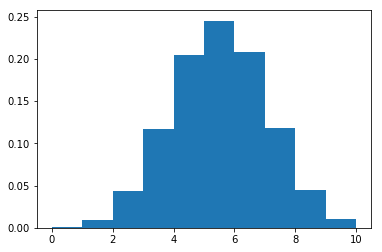

In [10]:
plt.hist(results, normed=True)
plt.show()

Podemos notar que o resultado encontrado possui um formato semelhante a uma curva normal, como era esperado. Explicação:

Nós podemos modelar o lançamento de uma moeda com probabilidade fixa utilizando a [distribuição de Bernoulli](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_de_Bernoulli). A probabilidade de obtermos um número ***k*** de sucessos ("caras") em um número fixo ***n*** de lançamentos (distribuição de Bernoulli) pode ser modelada por uma [distribuição binomial](https://en.wikipedia.org/wiki/Binomial_distribution). Enfim, pode-se [mostrar](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) que uma distribuição binomial se aproxima de uma distribuição normal com um valor de ***n*** suficientemente grande.

Suponha agora que realizamos um experimento com a moeda $P_2$ e obtivemos 2 caras e 8 coroas. Esse resultado indica que o dado é viciado?

### Nível de significância

Devemos introduzir o conceito de nível de significância para responder essa pergunta. O **nível de significância** (representado por $\alpha$) é a probabilidade limite considerada para rejeitarmos a hipótese nula, considerando que ela fosse verdade. Ou seja, é a mínima probabilidade que vamos considerar válida para não considerarmos o nosso resultado simples "acaso". Essa probabilidade atua como uma linha de corte para a nossa confiança no teste. Normalmente, esse nível de significância é definido pelo analista do teste anteriormente e valores comuns são 5%, 1% ou 0.1%. O oposto do nível de significância é chamado de "**nível de confiança**" ($1-\alpha$). 

---
*Exemplo: considerando o exemplo das caixas com bolas do começo da seção, qual seria a mínima probabilidade de que consideraríamos para aceitar a hipótese nula? E se ao invés de tirarmos 3 bolas vermelhas, nós tivéssemos tirado 1 bola vermelha e duas azuis (probabilidade = $0.05*\left(0.95\right)^2$ = $4.51\%$)? Ainda rejeitaríamos a hipótese nula? Se considerássemos um nível de significância de 5%, sim, mas um $\alpha$ = 1%, não.*

---

Perceba que a distribuição de probabilidade do número de caras é simétrica em relação ao centro (#caras = 5) e todas as probabilidades individuais devem somar a 1. Portanto, para considerarmos um nível de significância de $\alpha$ em um teste de hipóteses bilateral, nós precisamos dividir a região de corte em $\frac{\alpha}{2}$ para cada lado. Isso porque a probabilidade de todos os resultados dentro do [intervalo de confiança](#Intervalo-de-confiança) devem somar $1-\alpha$.

Suponha que consideramos um nível de significância $\alpha$ = 2%, ou seja, consideramos que qualquer evento cuja probabilidade é menor do que 1% será considerado muito raro para ser obtido "puramente ao acaso".

A região de corte utilizando tal nível significância é mostrada a seguir:

In [11]:
print('{:^10} | {:^10} | {:^10}'.format('caras', 'coroas', 'probabilidade'))
print('-'*40)
for i in range(len(count_heads)):
    if (i == 2) or (i == 9):
        print('*'*40)
    print('{:^10} | {:^10} | {:^10.2%}'.format(i, 10-i, count_heads[i]/n))

  caras    |   coroas   | probabilidade
----------------------------------------
    0      |     10     |   0.09%   
    1      |     9      |   0.92%   
****************************************
    2      |     8      |   4.30%   
    3      |     7      |   11.71%  
    4      |     6      |   20.47%  
    5      |     5      |   24.51%  
    6      |     4      |   20.75%  
    7      |     3      |   11.75%  
    8      |     2      |   4.42%   
****************************************
    9      |     1      |   0.97%   
    10     |     0      |   0.10%   


Portanto, qualquer resultado de um evento que estiver dentro dessa região é considerado válido e dizemos que "não temos evidência para rejeitar a hipótese nula". Ou seja, o evento não é tão raro assim para considerarmos algo "muito diferente" do que a hipótese nula definia.

Isso quer dizer que a hipótese nula é verdadeira?
- **Não!** Quer dizer que não temos evidência para dizer o contrário. Podemos ter mais confiança se realizarmos o ensaio mais vezes.

### Intervalo de confiança

O *intervalo de confiança* é o intervalo de valores que compõe o nível de confiança especificado, ou seja, a soma da probabilidade de todos os resultados dentro desse intervalo deve somar $1-\alpha$. Ao utilizarmos um nível de significância $\alpha$ = 2%, temos um nível de confiança de 98%, e, portanto, qualquer resultado que obtivermos dentro desse intervalo terá uma probabilidade elevada de ocorrer, considerando a hipótese nula verdadeira.

Para o exemplo das moedas, o intervalo de confiança para a quantidade de caras, utilizando um $\alpha$ = 2%, seria: I.C. = [2, 8]. Qualquer valor obtido fora desse intervalo nos permitiria rejeitar a hipótese nula.

### p-valor

O **p-valor** (do inglês, *p-value*) é um dos assuntos mais [controversos da estatística](https://en.wikipedia.org/wiki/P-value#Controversy), principalmente por seu uso equivocado na maioria dos casos. Por definição, o p-valor é a probabilidade de obter um resultado estatístico pelo *menos tão **extremo*** quanto o que foi observado, *assumindo que a hipótese nula é **verdadeira***. Ou seja, no caso das moedas, a probabilidade de obtermos apenas 1 "cara" em 10 jogadas é de, aproximadamente, 1%. Portanto, considerando que a hipótese nula é verdadeira, o p-valor desse resultado seria igual a 1%.

O p-valor ($p$) pode ser utilizado para rejeitar ou manter a hipótese nula. Define-se, em geral, que um resultado é estatisticamente significativo (ou seja, rejeita-se a hipótese nula) se o p-valor for menor do que o nível de significância dividido pelo **número de direções** do teste (teste unilateral: d=1, ou bilateral: d=2), ou seja
$$p < \frac{\alpha}{d}$$

### Tipos de erro

Ao realizarmos um teste de hipóteses, nós podemos cair em 4 cenários distintos:

- **Aceitamos** a hipótese nula e ela era, de fato, **verdadeira** (OK!)
- **Rejeitamos** a hipótese nula, mas ela era **verdadeira** (Erro tipo 1: Falso positivo)
- **Aceitamos** a hipótese nula, mas ela era **falsa** (Erro tipo 2: Falso negativo)
- **Rejeitamos** a hipótese nula e ela era, de fato, **falsa** (OK!)

A taxa de **erro tipo 1** é definida pelo nível de significância $\alpha$, ou seja, a proporção de vezes que detectamos uma variação, mas, na realidade, não houve.

A taxa de **erro tipo 2** é representada pela letra $\beta$. Já o seu oposto, $1-\beta$, representa o que chamamos de "poder do teste" (statistical power) e indica a porcentagem das vezes que vamos detectar uma variação, caso ela exista.

---
*Exemplo: Pegue o exemplo anterior das caixas e bolas. Nós vimos que a probabilidade de que uma pessoa tire 3 bolas vermelhas da caixa 1 é de 0.0125%. Mas, se 10000 pessoas repetissem esse experimentos, esperaríamos que esse fato ocorresse pelo menos uma vez. Se rejeitarmos a hipótese nula em todas as repetições, esperamos cometer um erro tipo 1 a cada 10000 experimentos.*

*Exemplo 2: Suponha um segundo cenário para o caso das caixas e bolas. Imagine agora que uma pessoa pegou 3 bolas azuis da caixa e afirmou que pegou elas da caixa 1. Nesse cenário, a probabilidade desse acontecimento é de $p = 0.95^3 = 85.7\%$ e, portanto, nós aceitamos a hipótese nula. O problema é que a pessoa mentiu e pegou essas bolas da caixa 2. Nesse caso, nós cometemos o erro tipo 2.*

---

### Tamanho da amostra

O tamanho da amostra é a quantidade de dados utilizados que compõe nossa amostra. Esse parâmetro está diretamente ligado ao **poder do teste**. Intuitivamente, é fácil notar que quanto mais dados utilizamos para realizar um teste de hipóteses, mais facilmente vamos notar uma variação, caso ela exista. Também podemos dizer que o teste se torna mais "sensível" a medida que utilizamos mais dados. 

Mas, se esse parâmetro é tão importante, por que não utilizamos valores altos?
- O problema é o alto custo para gerar dados. "Data is money" é uma expressão famosa e muito real nesse caso. Gerar dados leva muito tempo e pode ser muito caro. As vezes precisamos tirar conclusões com menos dados do que gostaríamos. E é exatamente por isso que precisamos aprender a **quantificar a nossa incerteza**.

### Significância prática / Efeito mínimo

Ao modelar um teste de hipóteses (como um teste A/B), precisamos entender nossas limitações de tempo e custo para poder definir o que esperamos encontrar no resultado. Por exemplo, vale a pena criarmos um teste de hipóteses com baixíssimas taxas de erro tipo 1 e 2, mas levarmos anos para conseguir todos os dados necessários? Algumas poucas vezes a resposta é "sim". Mas, na maioria das vezes, nós não precisamos de tanto poder estatístico (poder do teste) ou um nível de significância tão alto. As vezes, só importa para nós sermos capazes de observar uma variação significativa - pode ser 30% no caso de um teste de remédios, ou 2% no caso de trafego na Google - e qualquer coisa abaixo disso não nos interessa. Essa mínima variação observada pelo teste está diretamente relacionada com o poder do teste ($1-\beta$) e é chamado de **significância prática** ou **efeito mínimo** (em inglês, normalmente se adota o termo *effect size* ou *minimum effect*).

Agora temos todo o conteúdo necessário para iniciarmos nosso teste de hipóteses. Ao todo, temos 5 parâmetros que precisamos definir antes de realizarmos o teste:
- número de direções do teste ($d$)
- nível de significância ($\alpha$)
- poder do teste ($1-\beta$)
- tamanho da amostra (N)
- efeito mínimo ($e$)

Na prática, apenas 4 desses parâmetros são definidos e o último é calculado a partir dos outros. Normalmente, o parâmetro calculado é o tamanho da amostra.

Existem calculadoras online que nos permitem obter o tamanho da amostra dados os parâmetros. Esse [link](http://www.evanmiller.org/ab-testing/sample-size.html) é um site comumente utilizado.